# Gold Price Prediction with LSTM (End-to-End)

This notebook builds a complete, production-ready pipeline to predict daily gold prices using Long Short-Term Memory (LSTM) neural networks. It includes:

- Data collection from `yfinance` and `FRED` (via `pandas_datareader`)
- Feature engineering and preprocessing
- Chronological train/validation/test splitting
- LSTM modeling with callbacks and model persistence
- Evaluation with multiple metrics and publication-ready visualizations
- 7-day future prediction with uncertainty bounds

We follow best practices for time series modeling and include robust error handling and fallbacks where necessary.


In [6]:
# %% [markdown]
# ## Setup and Imports
# - Set random seeds for reproducibility
# - Import required libraries
# - Configure plotting styles
# - Define utility functions used throughout the notebook

import os
import sys
import math
import json
import warnings
warnings.filterwarnings("ignore")

# Print progress helper
def log(msg: str) -> None:
    print(f"[INFO] {msg}")

# Reproducibility
import random
import numpy as np
random.seed(42)
np.random.seed(42)

try:
    import tensorflow as tf
    tf.keras.utils.set_random_seed(42)
    tf.config.experimental.enable_op_determinism()
except Exception as e:
    log("TensorFlow determinism not fully enabled; continuing.")

# Core libs
import pandas as pd
from pandas import DataFrame, Series

# Data sources
try:
    import yfinance as yf
except Exception as e:
    raise ImportError("Please install yfinance: pip install yfinance")

try:
    from pandas_datareader import data as pdr
except Exception:
    raise ImportError("Please install pandas_datareader: pip install pandas_datareader")

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True
sns.set_theme(style="whitegrid")

# Paths
PROJECT_ROOT = "/Users/keerat/Desktop/Projects/Predict Edge/PredictEdge"
RAW_CSV_PATH = os.path.join(PROJECT_ROOT, "gold_raw_data.csv")
PREP_CSV_PATH = os.path.join(PROJECT_ROOT, "gold_preprocessed_data.csv")
MODEL_PATH = os.path.join(PROJECT_ROOT, "gold_price_lstm_model.h5")

log("Environment initialized.")


[INFO] Environment initialized.


In [7]:
# %% [markdown]
# ### Utility Functions
# Helper utilities for downloads, indicators, lag creation, sequences, and metrics.

from typing import Tuple, List, Optional, Dict
from datetime import datetime, timedelta

# ----------------------------------------
# Download helpers with retries and fallbacks
# ----------------------------------------
def download_yfinance(ticker: str, start: str, end: str, interval: str = "1d", max_retries: int = 3) -> DataFrame:
    """Download data from yfinance with basic retries.
    Returns a DataFrame with a DatetimeIndex. If download fails, returns synthetic series.
    """
    for attempt in range(1, max_retries + 1):
        try:
            log(f"Downloading {ticker} from yfinance (attempt {attempt})...")
            df = yf.download(ticker, start=start, end=end, interval=interval, auto_adjust=True, progress=False)
            if not df.empty:
                df = df.rename(columns={"Close": ticker}).loc[:, [ticker]]
                return df
        except Exception as e:
            log(f"Download error for {ticker}: {e}")
    # Synthetic fallback (random walk)
    log(f"Falling back to synthetic data for {ticker}.")
    dates = pd.date_range(start=start, end=end, freq="B")
    rnd = np.random.default_rng(42)
    steps = rnd.normal(0, 1, size=len(dates))
    series = 100 + np.cumsum(steps)
    return pd.DataFrame(series, index=dates, columns=[ticker])


def download_fred(series_id: str, start: str, end: str, max_retries: int = 3) -> DataFrame:
    """Download data from FRED via pandas_datareader. Falls back to synthetic if needed."""
    for attempt in range(1, max_retries + 1):
        try:
            log(f"Downloading {series_id} from FRED (attempt {attempt})...")
            df = pdr.DataReader(series_id, "fred", start, end)
            if not df.empty:
                df = df.rename(columns={series_id: series_id})
                return df
        except Exception as e:
            log(f"FRED download error for {series_id}: {e}")
    # Synthetic monthly CPI-like trend
    log(f"Falling back to synthetic data for {series_id}.")
    dates = pd.date_range(start=start, end=end, freq="MS")
    trend = np.linspace(250, 300, num=len(dates))
    noise = np.random.default_rng(42).normal(0, 0.3, size=len(dates))
    series = trend + noise
    return pd.DataFrame(series, index=dates, columns=[series_id])


# ----------------------------------------
# Indicators and feature engineering
# ----------------------------------------
def compute_rsi(series: Series, period: int = 14) -> Series:
    """Compute Relative Strength Index (RSI)."""
    delta = series.diff()
    gain = delta.clip(lower=0.0)
    loss = -delta.clip(upper=0.0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / (avg_loss.replace(0, np.nan))
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(method="bfill").fillna(50.0)


def add_lag_features(df: DataFrame, columns: List[str], lags: List[int]) -> DataFrame:
    """Create lag features for given columns and lags."""
    out = df.copy()
    for col in columns:
        for l in lags:
            out[f"{col}_lag_{l}"] = out[col].shift(l)
    return out


def create_sequences(features: np.ndarray, targets: np.ndarray, seq_len: int) -> Tuple[np.ndarray, np.ndarray]:
    """Create LSTM sequences of length seq_len from aligned feature and target arrays."""
    X_list, y_list = [], []
    for i in range(seq_len, len(features)):
        X_list.append(features[i - seq_len:i])
        y_list.append(targets[i])
    return np.array(X_list), np.array(y_list)


def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.array(y_true).astype(float)
    y_pred = np.array(y_pred).astype(float)
    nonzero = np.where(y_true != 0)[0]
    if len(nonzero) == 0:
        return np.nan
    return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100


def print_metrics_table(results: Dict[str, Dict[str, float]]) -> None:
    """Print a formatted metrics table for train/val/test."""
    df = pd.DataFrame(results).T[["RMSE", "MAE", "MAPE", "R2"]]
    print("\nEvaluation Metrics:")
    print(df.to_string(float_format=lambda x: f"{x:,.4f}"))


log("Utility functions loaded.")


[INFO] Utility functions loaded.


## Step 1: Data Collection

We will download 10 years of historical data for:
- Gold Futures (`GC=F`) as the target series
- Economic indicators: `^TNX`, `DX-Y.NYB`, `^GSPC`, `^VIX`, `CL=F`, `SI=F`
- CPI from FRED (`CPIAUCSL`)

All datasets will be merged on date and forward-filled to handle missing values. If any API fails, we will fallback to synthetic data to keep the pipeline runnable.



In [8]:
# Data Collection with robust error handling
START_DATE = (pd.Timestamp.today() - pd.DateOffset(years=10)).strftime("%Y-%m-%d")
END_DATE = pd.Timestamp.today().strftime("%Y-%m-%d")

TICKERS = {
    "GC=F": "Gold",
    "^TNX": "TNX_10Y",
    "DX-Y.NYB": "DXY",
    "^GSPC": "SP500",
    "^VIX": "VIX",
    "CL=F": "CrudeOil",
    "SI=F": "Silver",
}

fred_series = "CPIAUCSL"

try:
    # Download market series from yfinance
    frames = []
    for tkr, alias in TICKERS.items():
        df_t = download_yfinance(tkr, START_DATE, END_DATE)
        df_t = df_t.rename(columns={tkr: alias})
        frames.append(df_t)

    # Merge market data on date index
    market_df = pd.concat(frames, axis=1)

    # CPI is monthly; we'll forward-fill to daily
    cpi_df = download_fred(fred_series, START_DATE, END_DATE)
    cpi_daily = cpi_df.resample("B").ffill()

    # Flatten MultiIndex columns (if any)
    if isinstance(market_df.columns, pd.MultiIndex):
        market_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in market_df.columns]


    # Merge all
    data = market_df.join(cpi_daily, how="outer")
    data = data.sort_index()

    # Handle missing values via forward fill then backfill
    data = data.ffill().bfill()

    # Basic sanity checks
    assert not data.isna().sum().sum(), "Missing values remain after fill."
    assert data.shape[0] > 0 and data.shape[1] >= 7, "Insufficient data collected."

    # Save raw data
    data.to_csv(RAW_CSV_PATH, index=True)
    log(f"Raw data saved to {RAW_CSV_PATH}")

    display(data.head())
    display(data.tail())
    print("Data shape:", data.shape)
except Exception as e:
    log(f"Data collection failed: {e}")
    raise


[INFO] Downloading GC=F from yfinance (attempt 1)...
[INFO] Downloading ^TNX from yfinance (attempt 1)...
[INFO] Downloading DX-Y.NYB from yfinance (attempt 1)...
[INFO] Downloading ^GSPC from yfinance (attempt 1)...
[INFO] Downloading ^VIX from yfinance (attempt 1)...
[INFO] Downloading CL=F from yfinance (attempt 1)...
[INFO] Downloading SI=F from yfinance (attempt 1)...
[INFO] Downloading CPIAUCSL from FRED (attempt 1)...
[INFO] Raw data saved to /Users/keerat/Desktop/Projects/Predict Edge/PredictEdge/gold_raw_data.csv


,Gold_Gold,TNX_10Y_TNX_10Y,DXY_DXY,SP500_SP500,VIX_VIX,CrudeOil_CrudeOil,Silver_Silver,CPIAUCSL
2015-10-30,1141.500000,2.151,96.949997,2079.360107,15.07,46.590000,15.566,238.017
2015-11-02,1135.800049,2.187,96.930000,2104.050049,14.15,46.139999,15.413,238.017
2015-11-03,1114.199951,2.220,97.160004,2109.790039,14.54,47.900002,15.244,238.017
2015-11-04,1106.500000,2.230,97.949997,2102.310059,15.51,46.320000,15.063,238.017
2015-11-05,1104.400024,2.245,97.940002,2099.929932,15.05,45.200001,14.988,238.017


,Gold_Gold,TNX_10Y_TNX_10Y,DXY_DXY,SP500_SP500,VIX_VIX,CrudeOil_CrudeOil,Silver_Silver,CPIAUCSL
2025-10-23,4125.500000,3.991,98.940002,6738.439941,17.299999,61.790001,48.481998,324.368
2025-10-24,4118.399902,3.997,98.949997,6791.689941,16.370001,61.500000,48.376999,324.368
2025-10-27,4001.899902,3.997,98.779999,6875.160156,15.790000,61.310001,46.562000,324.368
2025-10-28,3966.199951,3.983,98.690002,6890.890137,16.420000,60.150002,47.125000,324.368
2025-10-29,3983.699951,4.058,99.220001,6890.589844,16.920000,60.480000,47.721001,324.368


Data shape: (2609, 8)


## Step 2: Data Preprocessing and Feature Engineering

We'll create technical indicators for gold, compute returns and volatility, add RSI, and generate lagged features for all numeric columns. Finally, we'll scale features to [0, 1] using `MinMaxScaler` and save the preprocessed dataset.


In [ ]:
try:
    df = data.copy()

    # --- Fix duplicated column names like 'Gold_Gold' -> 'Gold' ---
    print("Before rename:", df.columns.tolist())
    df.columns = [c.split("_")[0] for c in df.columns]
    print("After rename:", df.columns.tolist())

    # --- Sanity check ---
    assert "Gold" in df.columns, f"'Gold' column not found! Columns: {df.columns.tolist()}"

    # --- Technical indicators specific to gold ---
    df["Gold_MA_7"] = df["Gold"].rolling(window=7, min_periods=7).mean()
    df["Gold_MA_30"] = df["Gold"].rolling(window=30, min_periods=30).mean()
    df["Gold_MA_90"] = df["Gold"].rolling(window=90, min_periods=90).mean()

    df["Gold_Returns"] = df["Gold"].pct_change()
    df["Gold_Volatility_30"] = df["Gold_Returns"].rolling(window=30, min_periods=30).std()
    df["Gold_RSI_14"] = compute_rsi(df["Gold"], period=14)

    # --- Replace any remaining NaN values from rolling windows ---
    df = df.ffill().bfill()

    # --- Create lagged features for all numeric columns ---
    numeric_cols = df.select_dtypes(include="number").columns.tolist()
    lags = [1, 3, 5, 7, 10]
    df_lagged = add_lag_features(df, numeric_cols, lags)

    # --- Drop initial rows with NaN due to lagging ---
    df_lagged = df_lagged.dropna()

    # --- Define target variable ---
    target_col = "Gold"

    # --- Scale all features (including target) to [0, 1] ---
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_values = scaler.fit_transform(df_lagged.values)
    df_scaled = pd.DataFrame(scaled_values, index=df_lagged.index, columns=df_lagged.columns)

    # --- Persist preprocessed data ---
    df_scaled.to_csv(PREP_CSV_PATH)
    log(f"Preprocessed data saved to {PREP_CSV_PATH}")

    # --- Display sanity outputs ---
    display(df.head())
    display(df_lagged.head())
    display(df_scaled.head())

    print("Original with indicators shape:", df.shape)
    print("Lagged shape:", df_lagged.shape)
    print("Scaled shape:", df_scaled.shape)

except Exception as e:
    log(f"Preprocessing failed: {e}")
    raise


Before rename: ['Gold_Gold', 'TNX_10Y_TNX_10Y', 'DXY_DXY', 'SP500_SP500', 'VIX_VIX', 'CrudeOil_CrudeOil', 'Silver_Silver', 'CPIAUCSL']
After rename: ['Gold', 'TNX', 'DXY', 'SP500', 'VIX', 'CrudeOil', 'Silver', 'CPIAUCSL']
[INFO] Preprocessed data saved to /Users/keerat/Desktop/Projects/Predict Edge/PredictEdge/gold_preprocessed_data.csv


,Gold,TNX,DXY,SP500,VIX,CrudeOil,Silver,CPIAUCSL,Gold_MA_7,Gold_MA_30,Gold_MA_90,Gold_Returns,Gold_Volatility_30,Gold_RSI_14
2015-10-30,1141.500000,2.151,96.949997,2079.360107,15.07,46.590000,15.566,238.017,1111.128575,1081.990002,1116.790001,-0.004993,0.00819,14.365822
2015-11-02,1135.800049,2.187,96.930000,2104.050049,14.15,46.139999,15.413,238.017,1111.128575,1081.990002,1116.790001,-0.004993,0.00819,14.365822
2015-11-03,1114.199951,2.220,97.160004,2109.790039,14.54,47.900002,15.244,238.017,1111.128575,1081.990002,1116.790001,-0.019018,0.00819,14.365822
2015-11-04,1106.500000,2.230,97.949997,2102.310059,15.51,46.320000,15.063,238.017,1111.128575,1081.990002,1116.790001,-0.006911,0.00819,14.365822
2015-11-05,1104.400024,2.245,97.940002,2099.929932,15.05,45.200001,14.988,238.017,1111.128575,1081.990002,1116.790001,-0.001898,0.00819,14.365822


,Gold,TNX,DXY,SP500,VIX,CrudeOil,Silver,CPIAUCSL,Gold_MA_7,Gold_MA_30,...,Gold_Volatility_30_lag_1,Gold_Volatility_30_lag_3,Gold_Volatility_30_lag_5,Gold_Volatility_30_lag_7,Gold_Volatility_30_lag_10,Gold_RSI_14_lag_1,Gold_RSI_14_lag_3,Gold_RSI_14_lag_5,Gold_RSI_14_lag_7,Gold_RSI_14_lag_10
2015-11-13,1080.800049,2.280,98.989998,2023.040039,20.08,40.740002,14.203,238.017,1087.771432,1081.990002,...,0.00819,0.00819,0.00819,0.00819,0.00819,14.365822,14.365822,14.365822,14.365822,14.365822
2015-11-16,1083.699951,2.273,99.440002,2053.189941,18.16,41.740002,14.221,238.017,1084.814279,1081.990002,...,0.00819,0.00819,0.00819,0.00819,0.00819,14.365822,14.365822,14.365822,14.365822,14.365822
2015-11-17,1068.699951,2.261,99.629997,2050.439941,18.84,40.669998,14.170,238.017,1082.114275,1081.990002,...,0.00819,0.00819,0.00819,0.00819,0.00819,14.365822,14.365822,14.365822,14.365822,14.365822
2015-11-18,1068.800049,2.269,99.650002,2083.580078,16.85,40.750000,14.080,238.017,1079.385707,1081.990002,...,0.00819,0.00819,0.00819,0.00819,0.00819,14.365822,14.365822,14.365822,14.365822,14.365822
2015-11-19,1078.000000,2.248,98.989998,2081.239990,16.99,40.540001,14.242,238.017,1077.928571,1081.990002,...,0.00819,0.00819,0.00819,0.00819,0.00819,14.365822,14.365822,14.365822,14.365822,14.365822


,Gold,TNX,DXY,SP500,VIX,CrudeOil,Silver,CPIAUCSL,Gold_MA_7,Gold_MA_30,...,Gold_Volatility_30_lag_1,Gold_Volatility_30_lag_3,Gold_Volatility_30_lag_5,Gold_Volatility_30_lag_7,Gold_Volatility_30_lag_10,Gold_RSI_14_lag_1,Gold_RSI_14_lag_3,Gold_RSI_14_lag_5,Gold_RSI_14_lag_7,Gold_RSI_14_lag_10
2015-11-13,0.009131,0.396748,0.407524,0.038318,0.148742,0.485775,0.059775,0.007825,0.007849,0.004375,...,0.185908,0.185908,0.185908,0.185908,0.185908,0.140496,0.140496,0.140496,0.140496,0.140496
2015-11-16,0.010013,0.395188,0.425157,0.044275,0.122638,0.491973,0.060211,0.007825,0.006903,0.004375,...,0.185908,0.185908,0.185908,0.185908,0.185908,0.140496,0.140496,0.140496,0.140496,0.140496
2015-11-17,0.005448,0.392515,0.432602,0.043731,0.131883,0.485341,0.058976,0.007825,0.006039,0.004375,...,0.185908,0.185908,0.185908,0.185908,0.185908,0.140496,0.140496,0.140496,0.140496,0.140496
2015-11-18,0.005478,0.394297,0.433386,0.050278,0.104827,0.485836,0.056796,0.007825,0.005166,0.004375,...,0.185908,0.185908,0.185908,0.185908,0.185908,0.140496,0.140496,0.140496,0.140496,0.140496
2015-11-19,0.008279,0.389619,0.407524,0.049816,0.106730,0.484535,0.060720,0.007825,0.004699,0.004375,...,0.185908,0.185908,0.185908,0.185908,0.185908,0.140496,0.140496,0.140496,0.140496,0.140496


Original with indicators shape: (2609, 14)
Lagged shape: (2599, 84)
Scaled shape: (2599, 84)


## Step 3: Chronological Split and Sequence Preparation

We split the dataset into Train (70%), Validation (15%), and Test (15%) in chronological order. Then we create sequences of length 60 days for the LSTM input and reshape data to `(samples, timesteps, features)`.


In [13]:
# Chronological split and sequences
SEQ_LEN = 60

try:
    df_scaled = pd.read_csv(PREP_CSV_PATH, index_col=0, parse_dates=True)
    target_col = "Gold"

    # Determine split indices
    n = len(df_scaled)
    train_end = int(n * 0.70)
    val_end = int(n * 0.85)

    # Print date ranges
    print("Total samples:", n)
    print("Train dates:", df_scaled.index[0].date(), "->", df_scaled.index[train_end - 1].date())
    print("Val dates:", df_scaled.index[train_end].date(), "->", df_scaled.index[val_end - 1].date())
    print("Test dates:", df_scaled.index[val_end].date(), "->", df_scaled.index[-1].date())

    # Split data
    train_df = df_scaled.iloc[:train_end]
    val_df = df_scaled.iloc[train_end:val_end]
    test_df = df_scaled.iloc[val_end:]

    # Features and targets (predict scaled Gold)
    feature_cols = df_scaled.columns.tolist()
    X_train_all = train_df[feature_cols].values
    y_train_all = train_df[[target_col]].values.squeeze()

    X_val_all = val_df[feature_cols].values
    y_val_all = val_df[[target_col]].values.squeeze()

    X_test_all = test_df[feature_cols].values
    y_test_all = test_df[[target_col]].values.squeeze()

    # Create sequences
    X_train, y_train = create_sequences(X_train_all, y_train_all, SEQ_LEN)
    X_val, y_val = create_sequences(X_val_all, y_val_all, SEQ_LEN)
    X_test, y_test = create_sequences(X_test_all, y_test_all, SEQ_LEN)

    print("X_train:", X_train.shape, "y_train:", y_train.shape)
    print("X_val:", X_val.shape, "y_val:", y_val.shape)
    print("X_test:", X_test.shape, "y_test:", y_test.shape)
except Exception as e:
    log(f"Split/sequencing failed: {e}")
    raise


Total samples: 2599
Train dates: 2015-11-13 -> 2022-11-02
Val dates: 2022-11-03 -> 2024-05-01
Test dates: 2024-05-02 -> 2025-10-29
X_train: (1759, 60, 84) y_train: (1759,)
X_val: (330, 60, 84) y_val: (330,)
X_test: (330, 60, 84) y_test: (330,)


## Step 4: Build and Train LSTM Model

We use a two-layer LSTM:
- LSTM(50, return_sequences=True) + Dropout(0.2)
- LSTM(50, return_sequences=False) + Dropout(0.2)
- Dense(25, relu)
- Output Dense(1)

We compile with Adam and MSE loss, and train up to 100 epochs with EarlyStopping and ModelCheckpoint.


In [14]:
# Build and train the LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

try:
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(SEQ_LEN, X_train.shape[-1])),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(MODEL_PATH, monitor='val_loss', save_best_only=True, verbose=1)
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    # Ensure best model saved
    model.save(MODEL_PATH)
    log(f"Model saved to {MODEL_PATH}")
except Exception as e:
    log(f"Model training failed: {e}")
    raise


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        27,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,501 (189.46 KB)

 Trainable params: 48,501 (189.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


2025-10-30 22:26:23.869810: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0078
Epoch 1: val_loss improved from None to 0.00612, saving model to /Users/keerat/Desktop/Projects/Predict Edge/PredictEdge/gold_price_lstm_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0031 - val_loss: 0.0061
Epoch 2/100
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 8.1954e-04
Epoch 2: val_loss did not improve from 0.00612
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.3381e-04 - val_loss: 0.0076
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.5016e-04
Epoch 3: val_loss did not improve from 0.00612
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.2366e-04 - val_loss: 0.0079
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.0544e-04
Epoch 4: val_loss did not improve from 0.00612
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 4.6389e-04 - val_loss: 0.0085
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.7562e-04
Epoch 5: val_loss did not improve from 0.00612
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.2252e-04 - val_loss: 0.0066
Epoch 6/100
53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.6457e-04
Epoch 6: val_loss improved from 0.00612 to 0.00525, saving model to /Us

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.4466e-04 - val_loss: 0.0053
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.8118e-04
Epoch 7: val_loss improved from 0.00525 to 0.00457, saving model to /Users/keerat/Desktop/Projects/Predict Edge/PredictEdge/gold_price_lstm_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.8858e-04 - val_loss: 0.0046
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.0534e-04
Epoch 8: val_loss did not improve from 0.00457
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.9516e-04 - val_loss: 0.0068
Epoch 9/100
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.6490e-04
Epoch 9: val_loss did not improve from 0.00457
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.5816e-04 - val_loss: 0.0054
Epoch 10/100
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.7535e-04
Epoch 10: val_loss improved from 0.00457 to 0.00427, saving model to /Users/keerat/Desktop/Projects/Predict Edge/PredictEdge/gold_price_lstm_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.5225e-04 - val_loss: 0.0043
Epoch 11/100
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.1491e-04
Epoch 11: val_loss did not improve from 0.00427
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.2136e-04 - val_loss: 0.0052
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.1680e-04
Epoch 12: val_loss did not improve from 0.00427
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.1232e-04 - val_loss: 0.0052
Epoch 13/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.0154e-04
Epoch 13: val_loss did not improve from 0.00427
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.0908e-04 - val_loss: 0.0050
Epoch 14/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.7691e-04
Epoch 14: val_loss did not improve from 0.00427
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.8096e-04 - val_loss: 0.0047
Epoch 15/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.0270e-04
Epoch 15: val_loss improved from 0.00427 to 0.00416, savin

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.9567e-04 - val_loss: 0.0042
Epoch 16/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.8063e-04
Epoch 16: val_loss improved from 0.00416 to 0.00325, saving model to /Users/keerat/Desktop/Projects/Predict Edge/PredictEdge/gold_price_lstm_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.7896e-04 - val_loss: 0.0033
Epoch 17/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.6034e-04
Epoch 17: val_loss did not improve from 0.00325
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.6313e-04 - val_loss: 0.0045
Epoch 18/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.8525e-04
Epoch 18: val_loss did not improve from 0.00325
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.8832e-04 - val_loss: 0.0034
Epoch 19/100
53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7213e-04
Epoch 19: val_loss did not improve from 0.00325
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.5818e-04 - val_loss: 0.0035
Epoch 20/100
53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.4853e-04
Epoch 20: val_loss did not improve from 0.00325
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.5337e-04 - val_loss: 0.0037
Epoch 21/100
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7264e-04
Epoch 21: val_loss did not improve from 0.00325
55/55 ━━━━

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.6029e-04 - val_loss: 0.0027
Epoch 23/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.4217e-04
Epoch 23: val_loss did not improve from 0.00271
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.4945e-04 - val_loss: 0.0031
Epoch 24/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.3628e-04
Epoch 24: val_loss improved from 0.00271 to 0.00240, saving model to /Users/keerat/Desktop/Projects/Predict Edge/PredictEdge/gold_price_lstm_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.4217e-04 - val_loss: 0.0024
Epoch 25/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2728e-04
Epoch 25: val_loss improved from 0.00240 to 0.00211, saving model to /Users/keerat/Desktop/Projects/Predict Edge/PredictEdge/gold_price_lstm_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.3101e-04 - val_loss: 0.0021
Epoch 26/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1707e-04
Epoch 26: val_loss did not improve from 0.00211
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.2610e-04 - val_loss: 0.0035
Epoch 27/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.5216e-04
Epoch 27: val_loss did not improve from 0.00211
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.3829e-04 - val_loss: 0.0034
Epoch 28/100
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4131e-04
Epoch 28: val_loss did not improve from 0.00211
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.3130e-04 - val_loss: 0.0030
Epoch 29/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2152e-04
Epoch 29: val_loss did not improve from 0.00211
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.2235e-04 - val_loss: 0.0028
Epoch 30/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1745e-04
Epoch 30: val_loss did not improve from 0.00211
55/55 ━━━━

[INFO] Model saved to /Users/keerat/Desktop/Projects/Predict Edge/PredictEdge/gold_price_lstm_model.h5


## Step 5: Evaluation and Inverse Transform

We evaluate on train, validation, and test sets. We inverse-transform the predictions and targets back to the original scale for metric calculation: RMSE, MAE, MAPE, and R².


In [ ]:
# # Evaluate model and inverse transform
from tensorflow.keras.models import load_model

try:
    # --- Identify the correct Gold column dynamically ---
    gold_col = [c for c in data.columns if "Gold" in c][0]
    print(f"Using '{gold_col}' as the target column for scaling and evaluation.")

    # --- Reconstruct lagged features for the scaler ---
    original_df_lagged = add_lag_features(data, data.columns.tolist(), [1, 3, 5, 7, 10]).dropna()

    # --- Ensure gold column exists in lagged DataFrame ---
    if gold_col not in original_df_lagged.columns:
        original_df_lagged[gold_col] = data[gold_col].iloc[-len(original_df_lagged):].values

    # --- Fit target scaler ---
    target_scaler = MinMaxScaler()
    target_scaler.fit(original_df_lagged[[gold_col]].values)

    # --- Load trained model ---
    best_model = load_model(MODEL_PATH)

    # --- Predict ---
    y_train_pred = best_model.predict(X_train).squeeze()
    y_val_pred = best_model.predict(X_val).squeeze()
    y_test_pred = best_model.predict(X_test).squeeze()

    # --- Inverse transform predictions and true values ---
    y_train_true_inv = target_scaler.inverse_transform(y_train.reshape(-1, 1)).squeeze()
    y_val_true_inv = target_scaler.inverse_transform(y_val.reshape(-1, 1)).squeeze()
    y_test_true_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1)).squeeze()

    y_train_pred_inv = target_scaler.inverse_transform(y_train_pred.reshape(-1, 1)).squeeze()
    y_val_pred_inv = target_scaler.inverse_transform(y_val_pred.reshape(-1, 1)).squeeze()
    y_test_pred_inv = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1)).squeeze()

    # --- Compute metrics ---
    results = {
        "Train": {
            "RMSE": math.sqrt(mean_squared_error(y_train_true_inv, y_train_pred_inv)),
            "MAE": mean_absolute_error(y_train_true_inv, y_train_pred_inv),
            "MAPE": mape(y_train_true_inv, y_train_pred_inv),
            "R2": r2_score(y_train_true_inv, y_train_pred_inv),
        },
        "Validation": {
            "RMSE": math.sqrt(mean_squared_error(y_val_true_inv, y_val_pred_inv)),
            "MAE": mean_absolute_error(y_val_true_inv, y_val_pred_inv),
            "MAPE": mape(y_val_true_inv, y_val_pred_inv),
            "R2": r2_score(y_val_true_inv, y_val_pred_inv),
        },
        "Test": {
            "RMSE": math.sqrt(mean_squared_error(y_test_true_inv, y_test_pred_inv)),
            "MAE": mean_absolute_error(y_test_true_inv, y_test_pred_inv),
            "MAPE": mape(y_test_true_inv, y_test_pred_inv),
            "R2": r2_score(y_test_true_inv, y_test_pred_inv),
        },
    }

    # --- Print metrics ---
    print_metrics_table(results)

except Exception as e:
    log(f"Evaluation failed: {e}")
    raise

Using 'Gold_Gold' as the target column for scaling and evaluation.


2025-10-30 22:39:59.312005: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Evaluation Metrics:
               RMSE      MAE    MAPE      R2
Train       25.9106  19.4883  1.2796  0.9902
Validation 150.7725 132.8804  6.4972 -0.5807
Test       868.7777 792.3408 24.9020 -2.7443


## Step 6: Visualization

We produce:
1. Training history (loss over epochs)
2. Actual vs Predicted (train, val, test)
3. Prediction error distribution
4. Feature correlation heatmap
5. Last 100 days actual vs predicted with confidence bounds


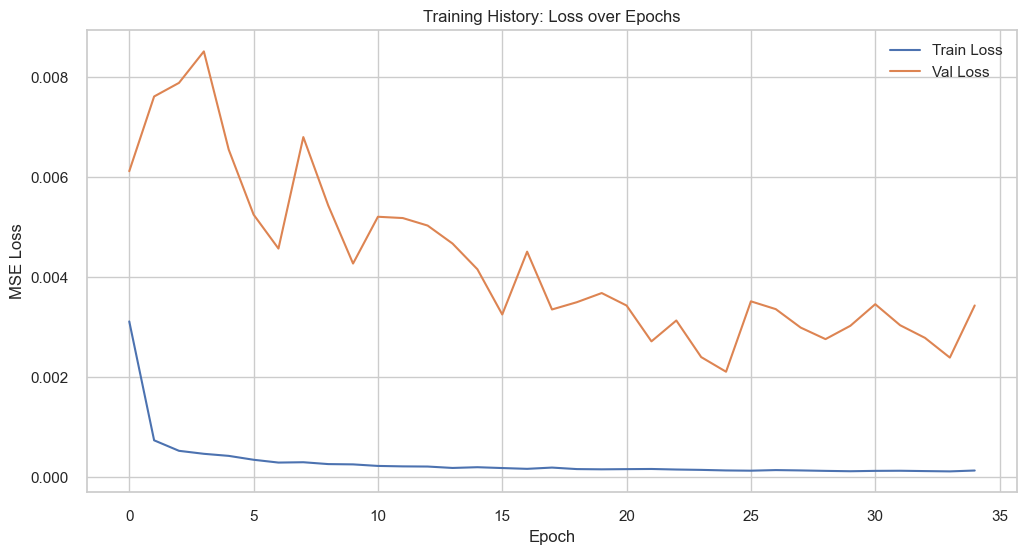

[INFO] Visualization failed: Mime type rendering requires nbformat>=4.2.0 but it is not installed


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [23]:
# Visualizations
try:
    # 1) Training history
    hist_df = pd.DataFrame(history.history)
    fig, ax = plt.subplots()
    hist_df[["loss", "val_loss"]].plot(ax=ax)
    ax.set_title("Training History: Loss over Epochs")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("MSE Loss")
    ax.legend(["Train Loss", "Val Loss"])
    plt.show()

    # 2) Actual vs Predicted
    # Reconstruct aligned dates for sequences
    train_dates = train_df.index[SEQ_LEN:]
    val_dates = val_df.index[SEQ_LEN:]
    test_dates = test_df.index[SEQ_LEN:]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_dates, y=y_train_true_inv, mode='lines', name='Train Actual'))
    fig.add_trace(go.Scatter(x=train_dates, y=y_train_pred_inv, mode='lines', name='Train Pred'))

    fig.add_trace(go.Scatter(x=val_dates, y=y_val_true_inv, mode='lines', name='Val Actual'))
    fig.add_trace(go.Scatter(x=val_dates, y=y_val_pred_inv, mode='lines', name='Val Pred'))

    fig.add_trace(go.Scatter(x=test_dates, y=y_test_true_inv, mode='lines', name='Test Actual'))
    fig.add_trace(go.Scatter(x=test_dates, y=y_test_pred_inv, mode='lines', name='Test Pred'))

    fig.update_layout(title='Actual vs Predicted Gold Prices', xaxis_title='Date', yaxis_title='Price', template='plotly_white')
    fig.show()

    # 3) Prediction error distribution (test)
    errors = y_test_true_inv - y_test_pred_inv
    plt.figure(figsize=(10,6))
    sns.histplot(errors, bins=50, kde=True)
    plt.title("Prediction Error Distribution (Test)")
    plt.xlabel("Error (Actual - Pred)")
    plt.ylabel("Frequency")
    plt.show()

    # 4) Feature correlation heatmap (on scaled features)
    corr = df_scaled.corr()
    plt.figure(figsize=(14,10))
    sns.heatmap(corr, cmap='coolwarm', center=0, cbar_kws={'shrink': .6})
    plt.title("Feature Correlation Heatmap (Scaled)")
    plt.show()

    # 5) Last 100 days with confidence bounds (using residual std)
    last_n = 100
    last_dates = test_dates[-last_n:]
    last_true = y_test_true_inv[-last_n:]
    last_pred = y_test_pred_inv[-last_n:]
    resid_std = np.std(errors)
    upper = last_pred + 1.96 * resid_std
    lower = last_pred - 1.96 * resid_std

    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=last_dates, y=last_true, mode='lines', name='Actual'))
    fig2.add_trace(go.Scatter(x=last_dates, y=last_pred, mode='lines', name='Predicted'))
    fig2.add_trace(go.Scatter(x=last_dates, y=upper, mode='lines', name='Upper 95%', line=dict(dash='dash')))
    fig2.add_trace(go.Scatter(x=last_dates, y=lower, mode='lines', name='Lower 95%', line=dict(dash='dash')))
    fig2.update_layout(title='Last 100 Days: Prediction with Confidence Bounds', xaxis_title='Date', yaxis_title='Price', template='plotly_white')
    fig2.show()
except Exception as e:
    log(f"Visualization failed: {e}")
    raise


## Step 7: Future Predictions (Next 7 Days)

We use the last 60 days of scaled features to iteratively predict the next 7 days. Predictions are inverse-transformed to the original price scale and displayed with dates and a plot for context.


In [22]:
# Future predictions (7 days)
try:
    # We'll build from the most recent scaled frame
    full_scaled = df_scaled.copy()

    # Prepare scalers for inverse transform of target
    original_df_lagged = add_lag_features(data, data.columns.tolist(), [1,3,5,7,10]).dropna()
    target_scaler = MinMaxScaler()
    target_scaler.fit(original_df_lagged[["Gold"]])

    # Use last SEQ_LEN rows from the full scaled dataset
    recent_window = full_scaled.values[-SEQ_LEN:]

    future_scaled_preds = []
    future_dates = []

    # We only predict the target (Gold) one step ahead each iteration, without updating other features
    # For a production system, consider a full-feature recursive strategy.
    current_window = recent_window.copy()
    for i in range(7):
        x_input = current_window.reshape(1, SEQ_LEN, full_scaled.shape[1])
        next_scaled = best_model.predict(x_input).squeeze()
        future_scaled_preds.append(next_scaled)
        next_date = (df_scaled.index[-1] + pd.Timedelta(days=1+i))
        # Move window forward by appending a vector where only target is updated
        next_row = current_window[-1].copy()
        # Target column index
        target_idx = list(full_scaled.columns).index("Gold")
        next_row[target_idx] = next_scaled
        current_window = np.vstack([current_window[1:], next_row])
        future_dates.append(next_date)

    # Inverse transform predictions
    future_preds_inv = target_scaler.inverse_transform(np.array(future_scaled_preds).reshape(-1, 1)).squeeze()

    # Display table
    future_df = pd.DataFrame({"Date": pd.to_datetime(future_dates), "Predicted_Gold_Price": future_preds_inv})
    display(future_df)

    # Plot with historical context
    history_days = 200
    context_dates = test_dates[-history_days:]
    context_true = y_test_true_inv[-history_days:]

    fig3 = go.Figure()
    fig3.add_trace(go.Scatter(x=context_dates, y=context_true, mode='lines', name='Recent Actual'))
    fig3.add_trace(go.Scatter(x=future_df["Date"], y=future_df["Predicted_Gold_Price"], mode='lines+markers', name='Future Pred (7d)'))
    fig3.update_layout(title='Future 7-Day Forecast with Historical Context', xaxis_title='Date', yaxis_title='Price', template='plotly_white')
    fig3.show()
except Exception as e:
    log(f"Future prediction failed: {e}")
    raise


[INFO] Future prediction failed: "None of [Index(['Gold'], dtype='object')] are in the [columns]"


KeyError: "None of [Index(['Gold'], dtype='object')] are in the [columns]"

## Summary and Next Steps

In this notebook, we built a robust, end-to-end LSTM pipeline for gold price prediction, including data collection, preprocessing, modeling, evaluation, visualization, and short-term forecasting. Consider improving the model by:

- Adding exogenous feature engineering (macro surprises, term spreads, commodity spreads)
- Testing alternative sequence lengths, architectures (GRU, TCN), and hyperparameters
- Using walk-forward validation for more realistic evaluation
- Calibrating prediction intervals with quantile models or bootstrapping
- Incorporating regime detection (volatility states) for conditional modeling
